In [306]:
import numpy as np

def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

def posterior_predictive(Phi_test, m_N, S_N, beta):
    
    # Compute mean of posterior predictive distribution
    y = Phi_test.dot(m_N)
    # Compute  variances of posterior predictive distribution
    var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, var

In [307]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)


def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)
def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'y-', alpha=0.5, label='Posterior samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'y-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior(mean, cov, w0, w1):
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')


def print_comparison(title, a, b, a_prefix='np', b_prefix='br'):
    print(title)
    print('-' * len(title))
    print(f'{a_prefix}:', a)
    print(f'{b_prefix}:', b)
    print()

In [308]:
import math
f_w0 = -0.3
f_w1 =  0.5




def f(X, noise_variance):
    # Linear function plus noise
    return f_w0 + f_w1 * X + noise(X.shape, noise_variance)


def sine(X, noise_variance):
    # Sinusoidial function plus noise
    return 0.5 + np.cos(3* np.pi * X) + 2*noise(X.shape, noise_variance)
def gamma(X,noise_variance , a): 
    b=(X**(a-1))*np.exp(-X)/math.gamma(a) +noise(X.shape, noise_variance)
   
    return b
  

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

In [309]:
def identity_basis_function(x):
    return x


def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, power):
    return x ** power
# Adding sigmoid basic function
def sigmoid_basis_function (x):
    return 1/(1 + np.exp(-x))
def cos_basis_function (x):
  
        def cal(x):
          return math.cos(x)
        applyall= np.vectorize(cal)
        res=applyall(x)
        return res


def expand(x, bf, bf_args=None ):
# This expand method add a column of 1  to  the Phi matrix
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

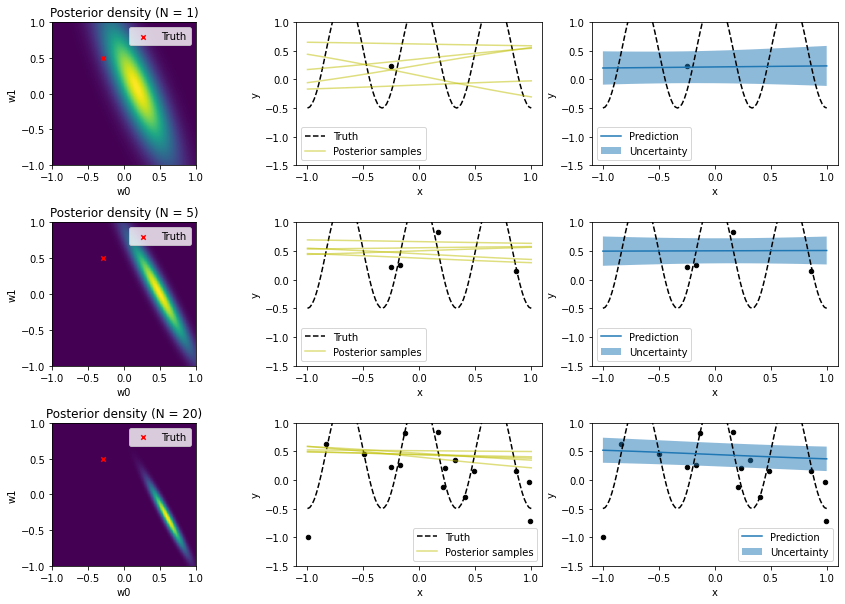

In [310]:


import matplotlib.pyplot as plt
%matplotlib inline

# Number of training observations for three cases : 1 observation, 5 observaions,
# 10 obseervation
N_list = [1,5, 20 ]

beta = 25.0
alpha = 2.0

# Crate 20 training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1) * 2 - 1

# Training target values

t = sine(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = sine(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, sigmoid_basis_function)

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, sigmoid_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 3, i * 3 + 1)
    plot_posterior(m_N, S_N, f_w0, f_w1)
    plt.title(f'Posterior density (N = {N})')
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 3)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.5, 1.0)
    plt.legend()



It can be seen that sigmoid basic function has low performance on this sine function with noise. My explaination is that since predicted mean of y is 

\begin{align}
       \small y&= \mathbf{m_N} \cdot {\phi}(x)=\frac{1}{1+e^{-x}} \\
       \frac{dy}{dx}&= \frac{e^{-x}}{(1+e^{-x})^2}
    \end{align}
Since the graph of $\frac{e^{-x}} {(1+e^{-x})^2}  $ is reasonably flat on (0,1) (can be checked with Desmo), it can be infered that the predicted line of y is significantly straight, which can not effectively capture the distribution of sine function. More over, the value of mean of  y is always greater than zero, which could not capture the range (-1,1) of sine function



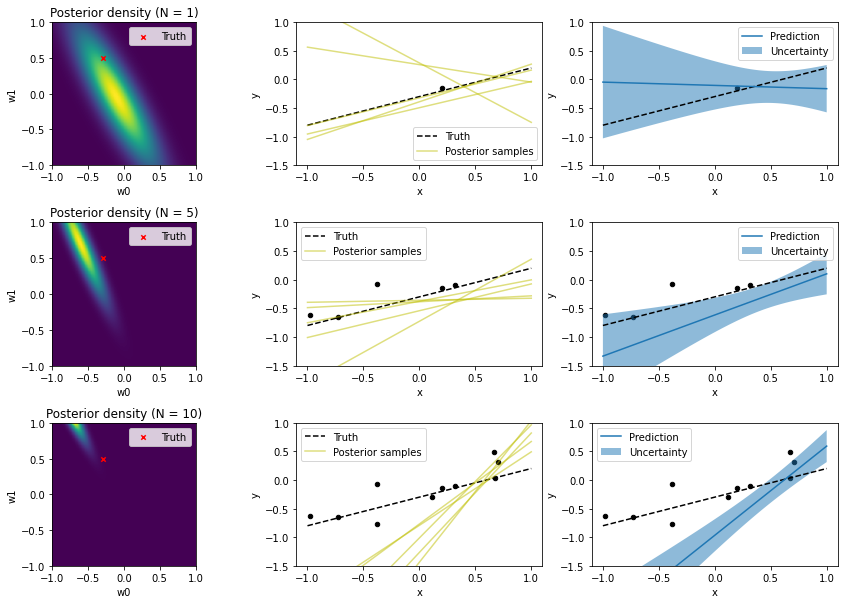

In [311]:


import matplotlib.pyplot as plt
%matplotlib inline

# Number of training observations for three cases : 1 observation, 5 observaions,
# 10 obseervation
N_list = [1,5, 10 ]

beta = 25.0
alpha = 2.0

# Crate 10 training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1) * 2 - 1

# Training target values
t = f(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = f(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, identity_basis_function)

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, sigmoid_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 3, i * 3 + 1)
    plot_posterior(m_N, S_N, f_w0, f_w1)
    plt.title(f'Posterior density (N = {N})')
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 3)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.5, 1.0)
    plt.legend()

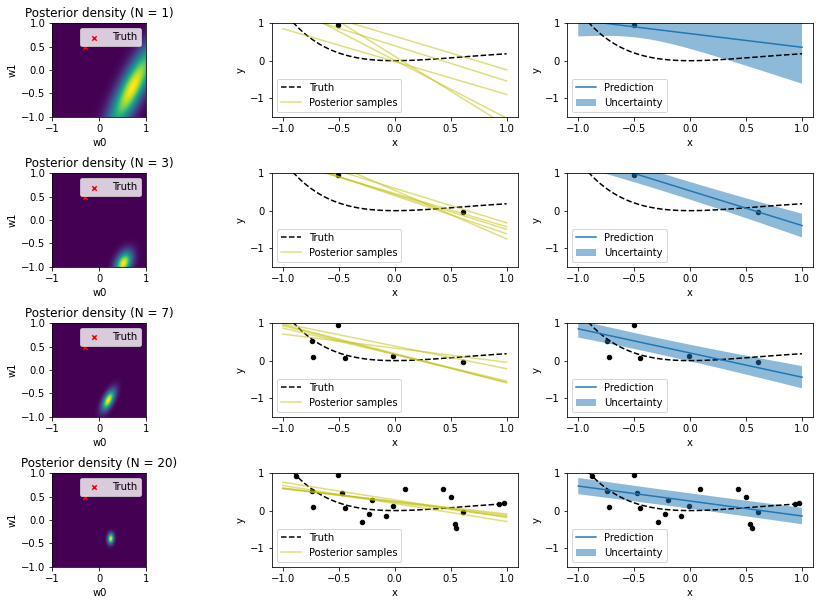

In [325]:


import matplotlib.pyplot as plt
%matplotlib inline

# Training dataset sizes
N_list = [1,3, 7, 20]

beta = 25.0
alpha = 2.0

# Crate 20 training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1) * 2 - 1

# Training target values
t = gamma(X, noise_variance=2/beta, a=3)

# Test observations
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = gamma(X_test, noise_variance=0,a=3)
    
# Design matrix of test observations
Phi_test = expand(X_test, identity_basis_function)

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.6)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, identity_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 3, i * 3 + 1)
    plot_posterior(m_N, S_N, f_w0, f_w1)
    plt.title(f'Posterior density (N = {N})')
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 3)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.5, 1.0)
    plt.legend()

Here, it can be seen that identity basic function is too simple to model the Gamma function

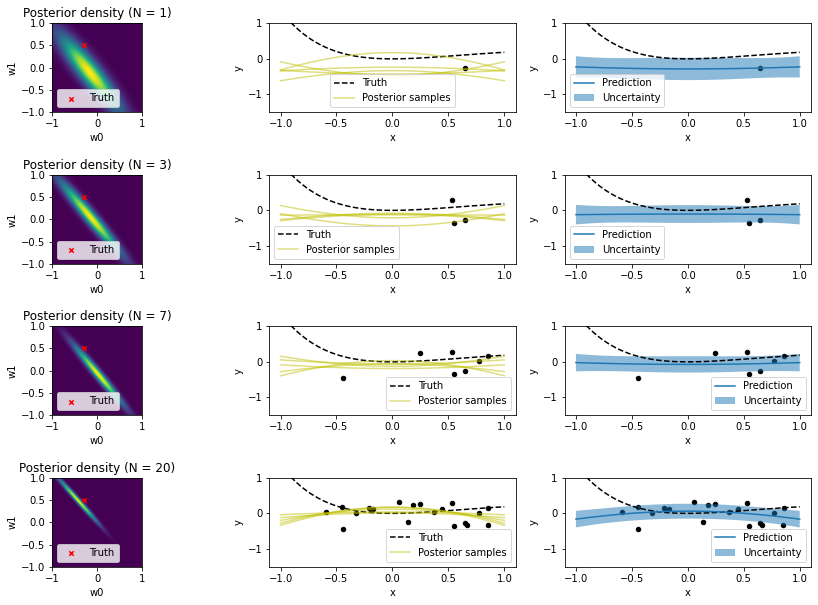

In [324]:
# Training dataset sizes
N_list = [1,3, 7, 20]

beta = 25.0
alpha = 2.0

# Crate 20 training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1) * 2 - 1

# Training target values
t = gamma(X, noise_variance=2/beta, a=3)

# Test observations
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = gamma(X_test, noise_variance=0,a=3)
    
# Design matrix of test observations
Phi_test = expand(X_test, cos_basis_function)

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.7)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, cos_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 3, i * 3 + 1)
    plot_posterior(m_N, S_N, f_w0, f_w1)
    plt.title(f'Posterior density (N = {N})')
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 3)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.5, 1.0)
    plt.legend()

Note that if the data is knowned to be within interval (-1,1), the basic fucntion cosine or sine could be a viable option since it derivatives is changing fast enough

(20, 1)


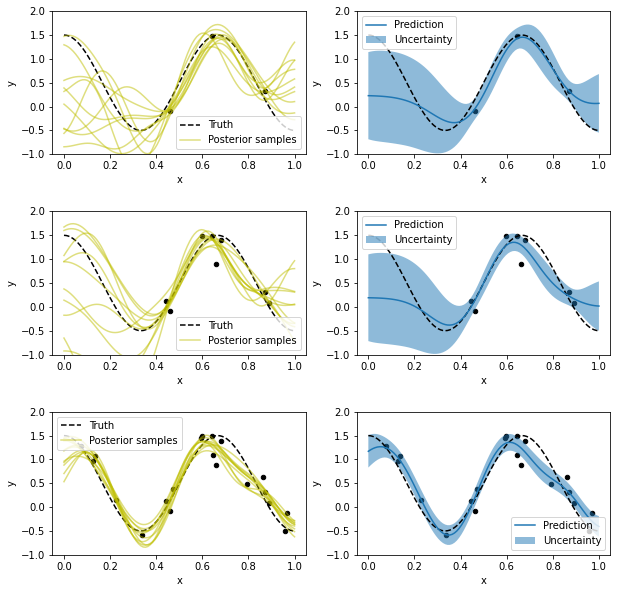

In [314]:
N_list = [3, 8, 20]

beta = 40.0
alpha = 2.0



# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1)
print (X.shape)
# Training target values
t = sine(X, noise_variance=1/beta)

# Test observations
#  here it plot a wide range of X_test, from discrete 100 observations, which can be the
#  generalize to continuos X_test over the in the interval with the help of numpy.plot
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

#  y values without noise 
y_true = sine(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 9))
# shape of phi test : (100,10)
plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 9))

    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 10 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 10).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 2, i * 2 + 1)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    
    plot_posterior_samples(X_test, y_samples)
    
    plt.ylim(-1.0, 2.0)
    plt.legend()
    
    plt.subplot(len(N_list), 2, i * 2 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.0, 2.0)
    plt.legend()

In [315]:
def log_marginal_likelihood(Phi, t, alpha, beta):
    """Calculate the log of the marginal likelihood."""
    N, M = Phi.shape

    m_N, _, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)
    
    E_D =  np.sum((t - Phi.dot(m_N)) ** 2)
    E_W =  np.sum(m_N ** 2)
    
    log_likelihood = M * np.log(alpha) + \
            N * np.log(beta) - \
            beta *E_D - \
            alpha *E_W - \
            np.log(np.linalg.det(S_N_inv)) - \
            N * np.log(2 * np.pi)

    return 0.5 * log_likelihood

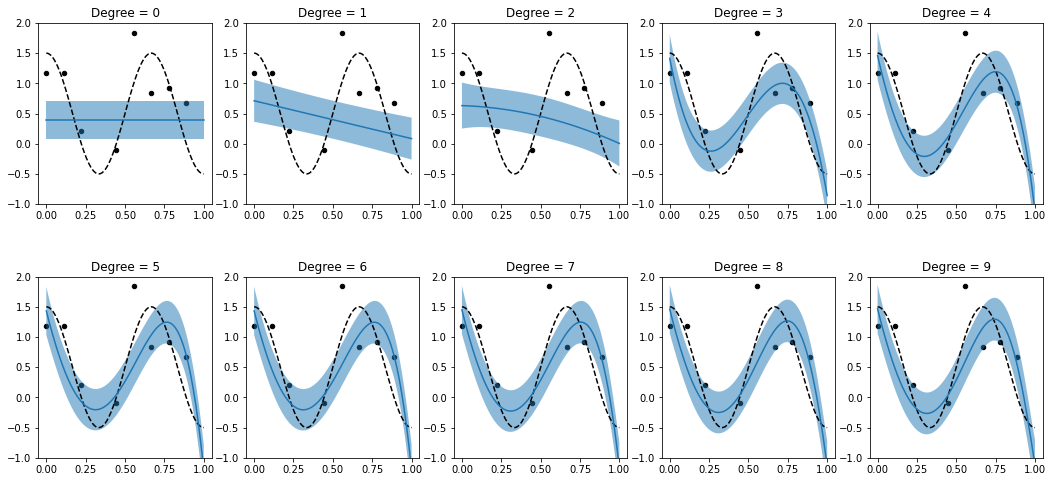

In [316]:
N = 10

beta = 1 / (0.3 ** 2)
alpha = 0.005

degree = 9
degrees = range(degree + 1)

X = np.linspace(0, 1, N).reshape(-1, 1)

t = sine(X, noise_variance=1/beta)

Phi = expand(X, bf=polynomial_basis_function, bf_args=degrees[1:])
Phi_test = expand(X_test, bf=polynomial_basis_function, bf_args=degrees[1:])

plt.figure(figsize=(18, 8))
plt.subplots_adjust(hspace=0.4)

for d in degrees:
    up = d + 1
    #  Here it only takes the columns of design matrix that degree is up to d
    m_N, S_N = posterior(Phi[:,:up], t, alpha, beta)
    # The same applies to y and y variance
    y, y_var = posterior_predictive(Phi_test[:,:up], m_N, S_N, beta)

    plt.subplot(2, 5, up)
    plot_data(X, t)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var), y_label=None, std_label=None, plot_xy_labels=False)
    plt.title(f'Degree = {d}')
    plt.ylim(-1.0, 2.0)

[-60.861631651277314, -62.50200592019532, -64.96759631834533, -42.91724512345517, -38.36688559454036, -38.33884684261335, -38.964464812536626, -39.27924871772335, -39.41945575163097, -39.58621650952421]


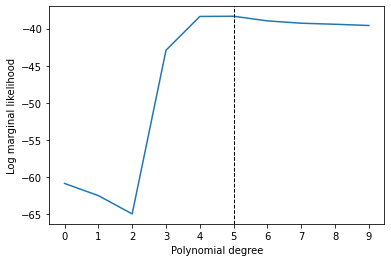

In [317]:
#  below is the graph plottting different value of  degree of polynominal with it marginal
# likelihood
mlls = []

for d in degrees:
    mll = log_marginal_likelihood(Phi[:,:d+1], t, alpha=alpha, beta=beta)
    mlls.append(mll)
print(mlls)
degree_max = np.argmax(mlls)
    
plt.plot(degrees, mlls)
plt.axvline(x=degree_max, ls='--', c='k', lw=1)
plt.xticks(range(0, 10))
plt.xlabel('Polynomial degree')
plt.ylabel('Log marginal likelihood');

Here, it can been seen that the higher degree of polynomial of basic function  lead to higher value of log marginal likelihood (it rises sharply at stage of degree 3). However,complex model with high degree may lead to severely overfit the data.
